In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
import torch

from files.training import generate_data, generate_data_elliptic

from Base.lla import dgala
from Base.utilities import clear_hooks

# Laplace Approx Burgers Eq

In [2]:
batch_size = [100,1500]

for i,bs in enumerate(batch_size):
    data_int,ini_c, left_bc, right_bc = generate_data(size=bs, nparam = 1, seed = 0, burgers=True)

    data_trainig = {"data_fit": {"pde":data_int, "ic_loss":ini_c,"bc_loss":(left_bc, right_bc)}, 
                    "class_method": {"pde": ["burgers_pde"], "ic_loss":["u"], "bc_loss":["u","u"]},
                    "outputs": {"pde": ["burgers"], "ic_loss": ["uic"],"bc_loss":["ubcl","ubcr"]}}

    burgers_model = torch.load(f"./models/Burgers_MDNN_s{bs}.pth")
    burgers_model.eval()

    llp = dgala(burgers_model)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, f"./models/burgers_lla_s{bs}.pth")

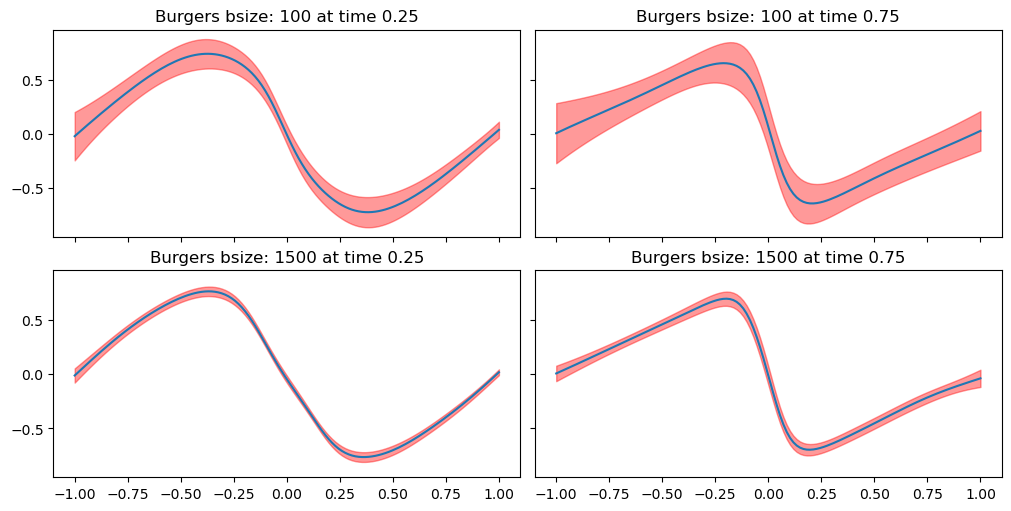

In [3]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction

param_ =  (0.01/np.pi)
batch_size = [100,1500]

for i,bs in enumerate(batch_size):
    
    burgers_model = torch.load(f"./models/Burgers_MDNN_s{bs}.pth")
    burgers_model.eval()

    llp = torch.load(f"./models/burgers_lla_s{bs}.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    for j,dt in enumerate([0.25,0.75]):
        data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

        nn_pred = burgers_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Burgers bsize: {bs} at time {dt}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

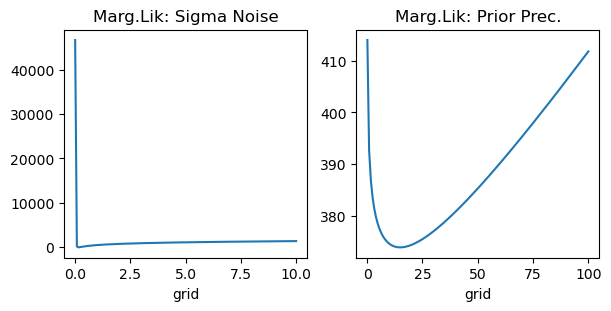

In [5]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/burgers_lla_s{100}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(10, 0.01, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,log_marg_lh)
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/burgers_lla_s{100}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(100, 0.1, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")


In [21]:
llp = torch.load(f"./models/burgers_lla_s{100}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.optimize_marginal_likelihood()
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00947, neg_marglik: 49.28603
Iteration 200, Error: 0.00567, neg_marglik: -125.00694
Iteration 300, Error: 0.00111, neg_marglik: -134.11751
Maximum iterations (300)reached, sigma : 0.15841791033744812, prior: 10.207696914672852.
tensor(0.1584) tensor([10.2077])


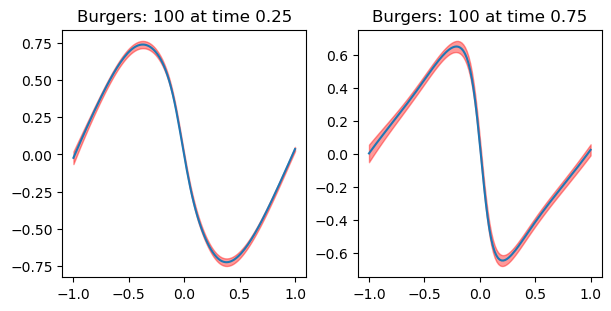

In [22]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')
X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction

param_ =  (0.01/np.pi)

burgers_model = torch.load(f"./models/Burgers_MDNN_s{100}.pth")
burgers_model.eval()

llp = torch.load(f"./models/burgers_lla_s{100}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

llp.sigma_noise = 0.1674
llp.prior_precision = 10

for j,dt in enumerate([0.25,0.75]):
    data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

    nn_pred = burgers_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Burgers: {100} at time {dt}")

# Heat

In [8]:
batch_size = [1000,3000]

for i,bs in enumerate(batch_size):
    data_int,ini_c, left_bc, right_bc = generate_data(size=bs, nparam = 1, seed = 0, burgers=False)

    data_trainig = {"data_fit": {"pde":data_int, "ic_loss":ini_c,"bc_loss":(left_bc, right_bc)}, 
                    "class_method": {"pde": ["heat_pde"], "ic_loss":["u"], "bc_loss":["u","u"]},
                    "outputs": {"pde": ["heat"], "ic_loss": ["uic"],"bc_loss":["ubcl","ubcr"]}}

    heat_model = torch.load(f"./models/Heat_MDNN_s{bs}.pth")
    heat_model.eval()

    llp = dgala(heat_model)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, f"./models/heat_lla_s{bs}.pth")

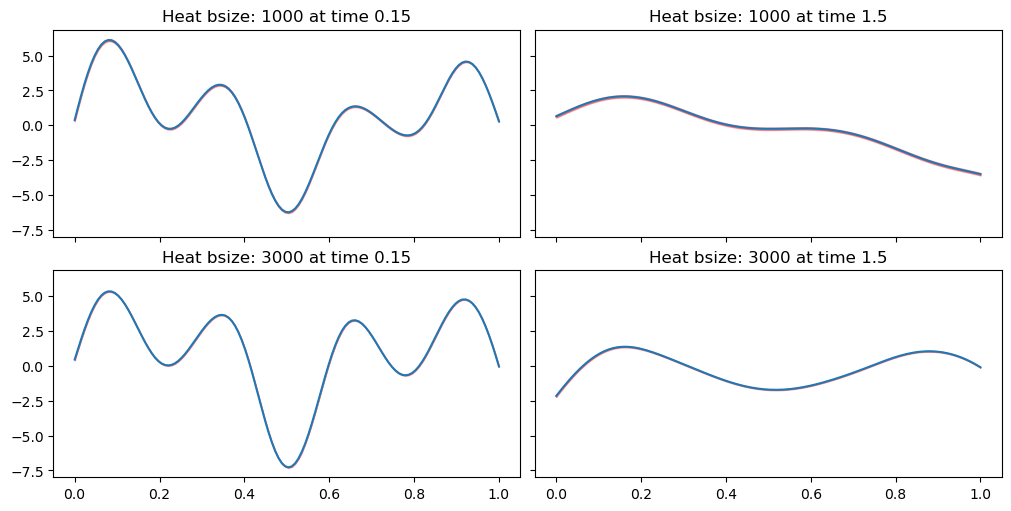

In [9]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

param_ =  0.001
batch_size = [1000,3000]

for i,bs in enumerate(batch_size):

    heat_model = torch.load(f"./models/Heat_MDNN_s{bs}.pth")
    heat_model.eval()

    llp = torch.load(f"./models/heat_lla_s{bs}.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    for j,dt in enumerate([0.15,1.5]):
        data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

        nn_pred = heat_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Heat bsize: {bs} at time {dt}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

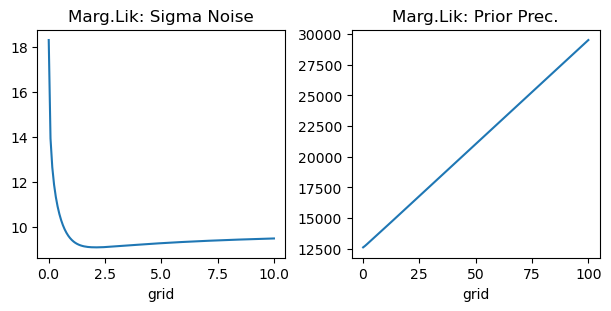

In [23]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/heat_lla_s{1000}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(10, 0.01, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/heat_lla_s{1000}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(100, 0.1, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")


In [12]:
llp = torch.load(f"./models/heat_lla_s{1000}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.optimize_marginal_likelihood()
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00454, neg_marglik: 8868.46582
Iteration 200, Error: 0.00236, neg_marglik: 8769.32520
Iteration 300, Error: 0.00157, neg_marglik: 8759.02148
Maximum iterations (300)reached, sigma : 2.104463577270508, prior: 0.17544075846672058.
tensor(2.1045) tensor([0.1754])


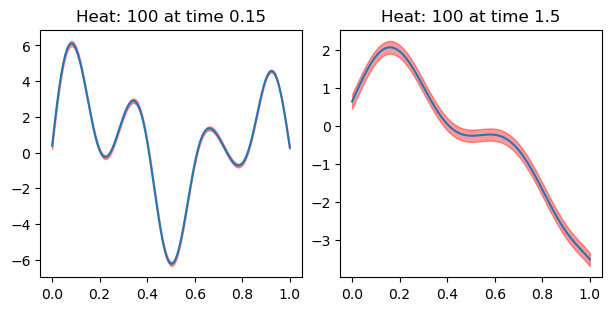

In [14]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

param_ =  0.001

heat_model = torch.load(f"./models/Heat_MDNN_s{1000}.pth")
heat_model.eval()

llp = torch.load(f"./models/heat_lla_s{1000}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

llp.sigma_noise = 2.
llp.prior_precision = [0.17]

for j,dt in enumerate([0.15,1.5]):
    data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

    nn_pred = heat_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Heat: {100} at time {dt}")

# Elliptic

In [15]:
batch_size = [150,2500]

for i,bs in enumerate(batch_size):

    data_int,left_bc,right_bc = generate_data_elliptic(size=bs) 

    data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
                "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
                "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    elliptic_model = torch.load(f"./models/MDNN_s{bs}.pth")
    elliptic_model.eval()

    llp = dgala(elliptic_model)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, f"./models/elliptic_lla_s{bs}.pth")

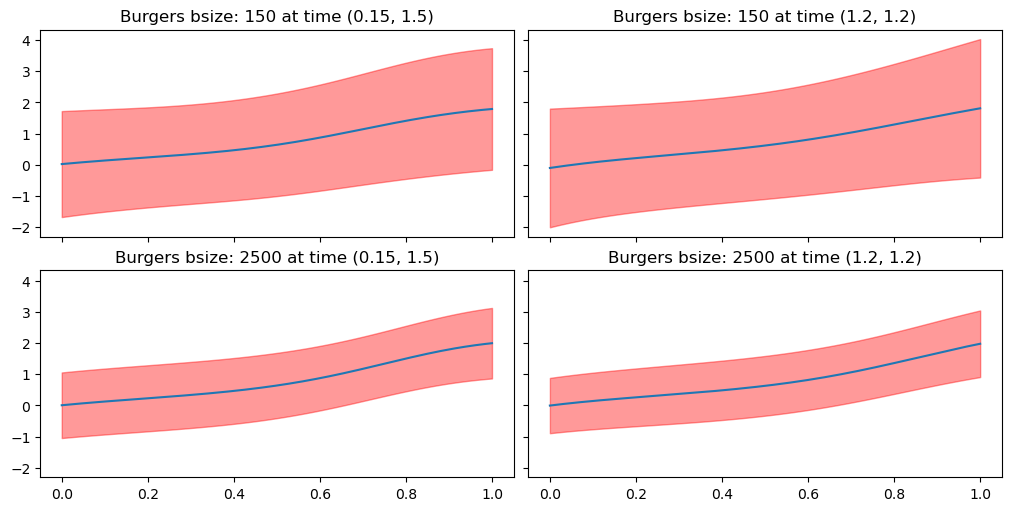

In [16]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

batch_size = [150,2500]

for i,bs in enumerate(batch_size):

    elliptic_model = torch.load(f"./models/MDNN_s{bs}.pth")
    elliptic_model.eval()

    llp = torch.load(f"./models/elliptic_lla_s{bs}.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    for j,pr in enumerate([(0.15,1.5),(1.2,1.2)]):

        data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * pr[0], torch.ones_like(X.reshape(-1,1)) * pr[1])).float()


        nn_pred = elliptic_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Burgers bsize: {bs} at time {pr}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

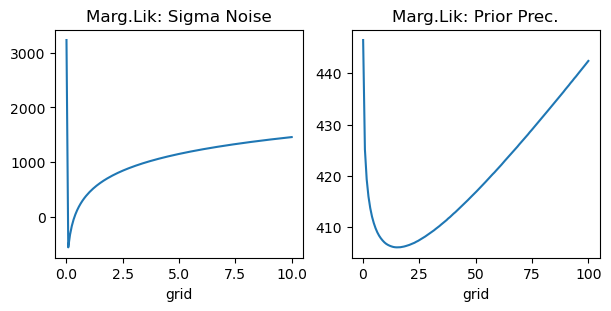

In [18]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(10, 0.01, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,log_marg_lh)
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(100, 0.1, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [ ]:
llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.optimize_marginal_likelihood()
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00977, neg_marglik: 6.01879
Iteration 200, Error: 0.00820, neg_marglik: -401.09805
Iteration 300, Error: 0.00428, neg_marglik: -654.32257
Maximum iterations (300)reached, sigma : 0.06335610151290894, prior: 10.394294738769531.
tensor(0.0634) tensor([10.3943])


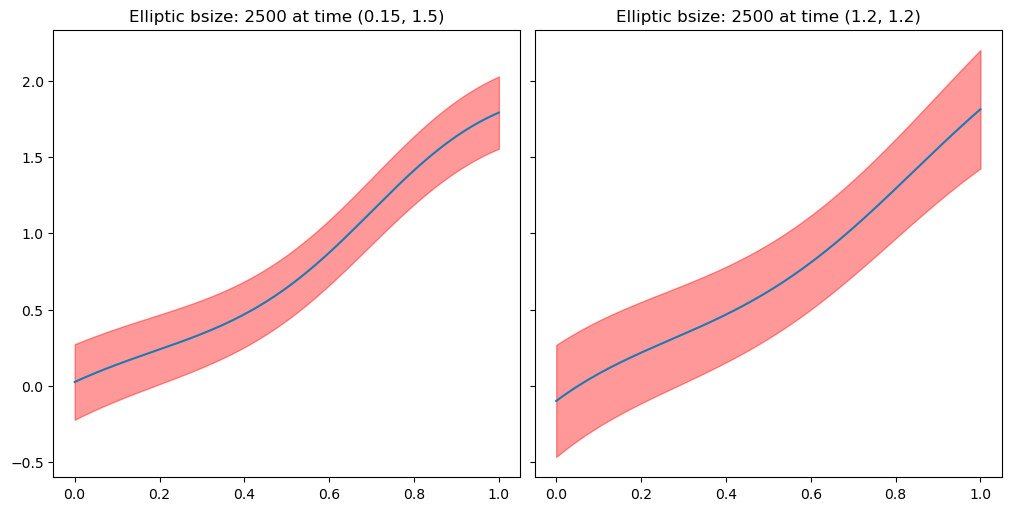

In [20]:
fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

elliptic_model = torch.load(f"./models/MDNN_s{150}.pth")
elliptic_model.eval()

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

llp.sigma_noise = 0.06
llp.prior_precision = 10

for j,pr in enumerate([(0.15,1.5),(1.2,1.2)]):

    data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * pr[0], torch.ones_like(X.reshape(-1,1)) * pr[1])).float()

    nn_pred = elliptic_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Elliptic bsize: {bs} at time {pr}")